In [31]:
import pandas as pd
import numpy as np
import csv 
import string
import nltk 
import re 
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import sys
import warnings
from os import path
import ast
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import jaccard_score
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.linear_model import RidgeClassifierCV

pd.options.display.max_seq_items = 2000
pd.options.display.max_colwidth = 90
pd.options.display.max_rows = 999

loggingFile = './experiment//TitleBody3GramTFIDF.txt'
binaryBodyTitle = './experiment/binaryBodyTitle.csv'
template = './experiment/dfTeste.csv'

In [32]:
#organizing data_frame to issue order
def organize():
    data_classes = pd.read_csv(binaryBodyTitle, header = 0, sep=";")
    data_classes

    del data_classes['prIssue']
    del data_classes['issueTitle']
    del data_classes['issueBody']

    data_classes.rename(columns={'issueComments': 'prComments','Comments': 'prCodeReviewComments','issueTitleLink': 'issueTitle','issueBodyLink': 'issueBody','issueCommentsLink': 'issue_Comments','pr': 'prNumber','issue': 'issueNumber', 'Title': 'prTitle','Body': 'prBody'}, inplace=True)
    categories = data_classes.columns.values.tolist()


    data_classes = data_classes[['issueNumber', 'prNumber', 'issueTitle', 'issueBody', 'issue_Comments',
                            'prTitle','prBody','prComments','prCodeReviewComments','commitMessage','isPR','isTrain',
                             'Google Common','Test','SO','IO','UI','Network','Security',
                            'OpenOffice Documents','Database','Utils','PDF','Logging','Latex']]

    data_classes['issueNumber'] = data_classes['issueNumber'].astype('Int64')
    
    return data_classes

In [33]:
#data_classes = organize()

In [34]:
#Filtering issues with PRs
def filtering(data_classes):
    IssuePRDataset = data_classes[data_classes["isTrain"] == 0]

    #invalid number of issue = NaN
    IssuePRDataset = IssuePRDataset.drop([1805])

    categories = IssuePRDataset.columns.values.tolist()
    
    return categories, IssuePRDataset

In [35]:
#categories, IssuePRDataset = filtering(data_classes)

In [36]:
# RQ1.a - o quão sensível o resultado é em relação ao algoritmo? 
#vários algoritmos - BinaryRelevance
#todas as palavras, bootstrap, unigram 
#somente o título
def dataset_config(IssuePRDataset):
    data_test1 = IssuePRDataset[['issueNumber','prNumber','issueTitle','Google Common', 'Test', 'SO', 'IO', 'UI', 'Network', 'Security', 
                           'OpenOffice Documents', 'Database', 'Utils', 'PDF', 'Logging', 'Latex']].copy()

    data_test1["corpus"] = data_test1["issueTitle"].map(str)
    del data_test1["issueTitle"]

    #removing utils because we won't to predict a so simple API that is basically used in all PRs
    del data_test1["Utils"]

    data_test1 = data_test1.reset_index(drop=True)
    
    return data_test1

In [37]:
#data_test1 = dataset_config(IssuePRDataset)

In [38]:
#preprocessing text

#We first convert the comments to lower-case 
#then use custom made functions to remove html-tags, punctuation and non-alphabetic characters from the TitleBody.

def clean_data(data_test1):
    if not sys.warnoptions:
        warnings.simplefilter("ignore")

    def cleanHtml(sentence):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', str(sentence))
        return cleantext

    def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
        cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        cleaned = cleaned.strip()
        cleaned = cleaned.replace("\n"," ")
        return cleaned

    def keepAlpha(sentence):
        alpha_sent = ""
        for word in sentence.split():
            alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
            alpha_sent += alpha_word
            alpha_sent += " "
        alpha_sent = alpha_sent.strip()
        return alpha_sent

    #function pra remover palavras com menos de 3 tokens

    data_test1['corpus'] = data_test1['corpus'].str.lower()
    data_test1['corpus'] = data_test1['corpus'].apply(cleanHtml)
    data_test1['corpus'] = data_test1['corpus'].apply(cleanPunc)
    data_test1['corpus'] = data_test1['corpus'].apply(keepAlpha)
    
    return data_test1


In [39]:
#data_test1 = clean_data(data_test1)

In [40]:
#### removing stopwords

def remove_stop_words():
    stop_words = set(stopwords.words('english'))
    stop_words.update(['pr','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','jabref','org','github','com','md','https','ad','changelog','','joelparkerhenderson','localizationupd',' localizationupd','localizationupd ','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the','Mr', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])
    #stop_words.update(['i', 'me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

    re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

    return re_stop_words

In [41]:
#re_stop_words = remove_stop_words()

In [42]:
def removeStopWords(sentence, re_stop_words):
    #global re_stop_words
    #print(sentence)
    return re_stop_words.sub(" ", sentence)

#removing words with less than 3 characters
#data_classes['titleBody'] = data_classes['titleBody'].str.findall('\w{3,}').str.join(' ')

In [43]:
#data_test1['corpus'] = data_test1['corpus'].apply(removeStopWords, re_stop_words=re_stop_words)


In [44]:
def apply_stem(data_test1):
    stemmer = SnowballStemmer("english")
    
    def stemming(sentence):
        stemSentence = ""
        for word in sentence.split():
            stem = stemmer.stem(word)
            stemSentence += stem
            stemSentence += " "
        stemSentence = stemSentence.strip()
        return stemSentence
    
    data_test1['corpus'] = data_test1['corpus'].apply(stemming)
    print(data_test1['corpus'])
    
    return data_test1


In [45]:
#data_test1 = apply_stem(data_test1)

In [46]:
#TF-ID
def run_tf_idf(data, configurationTFIDF, num_feature, tfIDFoutputFile):
    #we need to text max_feature with 10, 20, 25, 50 
    #, max_features=num_feature
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range = configurationTFIDF, max_features=num_feature)
        
    tf_idf_results = vectorizer.fit_transform(data['corpus'])

    features = vectorizer.get_feature_names()

    print(features)

    scores = (tf_idf_results.toarray())
    output_tf_idf = pd.DataFrame(scores)
    
    output_tf_idf = pd.concat([data['issueNumber'], output_tf_idf], axis=1)

    output_tf_idf.to_csv(tfIDFoutputFile, encoding='utf-8', header=False, index=False, sep=',')


    # remove words occuring less than 5 times
    #tfidf = TfidfVectorizer(min_df=5)
    #you can also remove common words:

    # remove words occuring in more than half the documents
    #tfidf = TfidfVectorizer(max_df=0.5)
    #you can also remove stopwords like this:
    

In [47]:
#use one of the data_test's (1 to 11) e.g data_test5

#run_tf_idf(data_test1, configurationTFIDF, num_feature, tfIDFoutputFile)


In [48]:
#analyzing frequency of TOP 50 terms

def analyze_top(data, termFrequencyTop50):
    docs = data['corpus'].tolist()

    cv = CountVectorizer()
    cv_fit=cv.fit_transform(docs)

    #print(cv.get_feature_names())
    #print(cv_fit.toarray())

    word_list = cv.get_feature_names()   

    count_list = cv_fit.toarray().sum(axis=0)
    term_frequency = dict(zip(word_list,count_list))

    a = sorted(term_frequency.items(), key=lambda x: x[1], reverse=True) 

    top50 = a[:100]
    df_frequency = pd.DataFrame(top50, columns =['term', 'frequency'])  

    print(df_frequency)

    df_frequency.to_csv(termFrequencyTop50, encoding='utf-8', header=False, index=False, sep=',')

    sns.set(font_scale = 2)
    plt.figure(figsize=(18,17))
    plt.xticks(rotation=90)
    plt.title("Frequency of terms ")
    plt.ylabel('term', fontsize=20)
    plt.xlabel('frequency', fontsize=20)
    ax = sns.barplot(x="frequency", y="term", data=df_frequency)
    
    return docs


In [49]:
#docs = analyze_top(data_test1, termFrequencyTop50)

In [50]:
#merging features TF-IDF with data_frame
def merging(data_test1, tfIDFoutputFile):
    feature = pd.read_csv(tfIDFoutputFile, header=None, sep=",")
    feature.rename(columns={0: 'issueNumber'}, inplace=True)

    data_classifier = data_test1.join(feature, lsuffix='issueNumber', rsuffix='issueNumber')

    categories = data_classifier.columns.values.tolist()
    
    return data_classifier, categories


In [51]:
#data_classifier, categories = merging(data_test1)

In [52]:
def eval_metrics(predictions, probabilities, y_test):
    
    y_pred = predictions.values
    y_proba = probabilities.values

    #receiving the y_test true value from each pull request
    y_true = y_test.to_numpy()

    print("Accuracy Score")
    acc_ml = accuracy_score(y_true, y_pred)
    print(acc_ml)

    print("---------")
    print("")

    print("Accuracy Score not normalized")
    acc_score = accuracy_score(y_true, y_pred, normalize=False)
    print(acc_score)

    print("---------")
    print("")

    print("zero_one_loss")
    zeroOne = zero_one_loss(y_true, y_pred)
    print(zeroOne)

    print("---------")
    print("")

    print("Fmeasure Score")
    fmeasure_score = f1_score(y_true,y_pred, average='micro')
    #fmeasure_score = f1_score(y_true,y_pred, average='macro')
    print(fmeasure_score)

    print("---------")
    print("")

    #AUC-PR
    print("AUC-PR")
    pr_score = average_precision_score(y_true,y_proba,average='micro')
    print(pr_score)
    #pr_score = average_precision_score(y_true,y_proba,average='macro')

    print("---------")
    print("")


    print("hamming loss average")
    hamming_loss = skm.hamming_loss(y_true, y_pred)
    print(hamming_loss)

    print("---------")
    print("")

    print("Jaccard samples")
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    print(jaccard_score_samples)

    print("---------")
    print("")


    print("Jaccard macro")
    jaccard_macro = jaccard_score(y_true, y_pred, average='micro')
    print(jaccard_macro)
    #jaccard_score(y_true, y_pred, average=None)

    print("---------")
    print("")

    return y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro

In [53]:
def plot_classes(probability, y_true, y_test):
    precision = dict()
    recall = dict()
    average_precision = dict()

    n_classes = y_test.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probability[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], probability[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),probability.ravel())

    average_precision["micro"] = average_precision_score(y_true, probability, average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))


In [197]:
import io
def confusion_matrix(y_true, y_pred, confusionMatrix, i):

    data = multilabel_confusion_matrix(y_true, y_pred)
    
    labels = ['Google Common', 'Test', 'SO', 'IO', 'UI', 'Network',
              'Security', 'OpenOffice Documents', 'Database','PDF',
              'Logging','Latex']
      
    metrics = pd.DataFrame()
    line = []
    dataLine = ""
    dataLine = "Label, TN, FP, FN, TP"
    line.append((dataLine))

    for j in range (0,12):
        print(j)
        row = data[j]
        dataLine=""
        dataLine = labels[j] 
        print(dataLine)
        for x in np.nditer(row):
            dataLine = dataLine + "," + str(x)
            print(dataLine)
        line.append((dataLine))
        print(line)
        
        metrics = pd.DataFrame(line)
    
    metrics.to_csv(confusionMatrix + str(i) +'.csv' , encoding='utf-8', header=True, index=False , sep=',')
    

In [198]:
#build the model 

def build_model(test_type):

    if test_type == "DecisionTree":
        clf = BinaryRelevance(classifier=DecisionTreeClassifier(), require_dense = [False, True])
        #clf = ClassifierChain(classifier=DecisionTreeClassifier(), require_dense = [False, True])
    if test_type == "LogisticRegression":
        clf = BinaryRelevance(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
        #clf = ClassifierChain(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
    if test_type == "RandomForest": 
        clf = BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
        #clf = ClassifierChain(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
    if test_type == "MLPClassifier":
        clf = BinaryRelevance(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
        #clf = ClassifierChain(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
    if test_type == "MLkNN":
        clf = BinaryRelevance(MLkNN(k=3))
        #clf = ClassifierChain(classifier=MLkNN(k=3))

    #This three works without probability
    if test_type == "LinearSVC":
        clf = BinaryRelevance(classifier=LinearSVC(), require_dense = [False, True])
    if test_type == "GaussianNB":
        clf = BinaryRelevance(classifier=GaussianNB(), require_dense = [False, True])
    if test_type == "RidgeClassifierCV":
        clf = BinaryRelevance(classifier=RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]), require_dense = [False, True]) 
    if test_type == "BRkNNaClassifier":
        clf = BinaryRelevance(BRkNNaClassifier(k=3))

        
    return clf

In [199]:
def save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type):

    line=[] 
    # line to csv report file
    
    names = ['Google Common',
'Test',
'SO',
'IO',
'UI',
'Network',
'Security',
'OpenOffice Documents',
'Database',
'PDF',
'Logging',
'Latex']
    

    prec, rec, fscore, sup = precision_recall_fscore_support(y_true,y_pred, average='micro')


    arr = [acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro,prec,rec, fscore]
    columns = ['Accuracy','Acc-Score','zero_one_loss','AUC-PR','hamming loss average','Jaccard samples','Jaccard macro','Precision','Recall','Fmeasure']
  
    df_metrics2 = pd.DataFrame([arr],columns=columns)
    print(df_metrics2)

    print("---------")
    print("")

    x = precision_recall_fscore_support(y_true,y_pred, average=None)
    print("")
    print("")

    df_metrics_by_class = pd.DataFrame.from_records(x, columns=names, index=['precision','recall','f-measure','samples_tested'])
    print(df_metrics_by_class)

    print("---------")
    print("")

    df_metrics2.to_csv(modelMatrix, encoding='utf-8', header=True, index=False, sep=',')    

    df_metrics_by_class.to_csv(metrics_by_class, encoding='utf-8', header=True, index=False, sep=',')    

    dataLine = ""
    dataLine = "tf-IDFMin, tf-IDFMax, #_TopTerms,Stop_Word,Train/Test_Size,Algorithm,Accuracy_Score,Accuracy_Score_not_normalized,zero_one_loss, AUC-PR,hamming_loss_avg,Jaccard_samples,Jaccard_macro,Precision,Recall,Fmeasure_Score, i"
    line.append((dataLine))
    dataLine =  str(configurationTFIDF) + "," + str(num_feature) + "," + stop_word + "," + str(size_test) + "," + str(test_type) + "," + str(acc_ml) + ","+ str(acc_score) + ","+ str(zeroOne) + "," + str(pr_score) + ","+ str(hamming_loss) + ","+ str(jaccard_score_samples) + ","+ str(jaccard_macro)+"," + str(prec)+","+str(rec)+","+str(fscore)+","+str(i) 
    line.append((dataLine))
    print(line)

    metrics = pd.DataFrame(line)
    metrics.to_csv('./experiment/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.csv', encoding='utf-8', header=False, index=False, sep=',')    
    np.savetxt(r'./experiment/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.txt', metrics.values, fmt='%s', delimiter=',')

    return prec, rec, fscore, sup

In [200]:
import datetime

def persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i):
    now = datetime.datetime.now()

    templateData = pd.read_csv(template, sep=',')
    
    print ("Current date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    headerdf = ['date_time','tf-IDF', '#_TopTerms','Stop_Word','Train/Test_Size','Algorithm','Accuracy_Score',
                'Accuracy_Score_not_normalized','zero_one_loss', 'AUC-PR','hamming_loss_avg','Jaccard_samples',
                'Jaccard_macro','Precision','Recall','Fmeasure_Score','i']


    tup = ( now,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i))

    print("tupla:", tup)
    print(len(tup))

    list_tup  = [ now,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i)]


    dfTeste = pd.DataFrame.from_records(data=[tup], columns=[headerdf])

    data_list = templateData.values.tolist()
    data_list.append(list_tup)
    new_data = pd.DataFrame(data_list)  
    for row in templateData.itertuples():
        print(row)

    new_data.to_csv('./experiment/dfTeste.csv', encoding='utf-8', index=False, sep=',', header=headerdf)  
    

In [201]:
def run_split(data_classifier, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test):
    train = []
    test = []

    X = data_classifier

    rs = ShuffleSplit(n_splits=splits, test_size= size_test, random_state=52)
    rs.get_n_splits(X)

    for train_index, test_index in rs.split(X):
         #print("%s %s" % (train_index, test_index))
         train.append(train_index)
         test.append(test_index)
        
    for i in range(0, len(train)):
 
        size_features = len(X.columns)
        data = data_classifier.ix[train[i]]
        X_train = data.iloc[:,15:size_features]
        #del X_train['issueNumberissueNumber']
        y_train = data.loc[:,'Google Common':'Latex']

        data = data_classifier.ix[test[i]]
        X_test = data.iloc[:,15:size_features]
        y_test = data.loc[:,'Google Common':'Latex']

        categories = y_test.columns.values.tolist()
        ids = y_test.index

        classifier_setup = build_model(test_type)
    
        clf = classifier_setup
        clf.fit(X_train,y_train)

        predict = clf.predict(X_test).toarray()
        probability = clf.predict_proba(X_test).toarray()

        predictions = pd.DataFrame(predict, index=ids, columns=categories) # with header
        probabilities = pd.DataFrame(probability, index=ids, columns=categories) # with header

        y_pred = predictions.values
        y_proba = probabilities.values

        y_true = y_test.to_numpy()

        y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro = eval_metrics(predictions, probabilities, y_test)

        plot_classes(probability, y_true, y_test)

        confusion_matrix(y_true, y_pred, confusionMatrix, i)
        
        prec, rec, fscore, sup = save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type)

        persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i)
        

In [202]:
#number of shuffles (folds)
splits=10

#defining paths
loggingFile = './experiment//TitleBody3GramTFIDF.txt'
binaryBodyTitle = './experiment/binaryBodyTitle.csv'
template = './experiment/dfTeste.csv'

configurationTFIDFList = [(1,1)]
#configurationTFIDFList = [(1,1),(2,2),(3,3),(4,4)]
#num_featureList = [25,50,100,500,1000,2500,5000]
num_featureList = [900]
size_testList = [0.2]
#size_testList = [0.2,0.3,0.4]
stop_wordList = ["Yes"]
#test_typeList = ["RandomForest","DecisionTree","LogisticRegression","MLPClassifier","MLkNN"]
test_typeList = ["RandomForest"]

#examples
#configurationTFIDFList = [(1,1),(2,2)]
#num_featureList = [25,50]
#size_testList = [0.2,0.3]
#stop_wordList = ["Yes","No"]
#test_typeList = ["RandomForest","DecisionTree"]

configurationTFIDF=(1,1)
num_feature=25

size_test=0.2

#stop_word = stop_wordList[i]
stop_word = "Yes"

test_type = "RandomForest"
# dont forget to have the file dfTeste.csv ready in the files folder only with the header!

def __main__():

    # getting length of list 
    lengthT = len(configurationTFIDFList) 
    lengthF = len(num_featureList) 
    lengthS = len(size_testList)
    lengthY = len(test_typeList)
    
    # Iterating the index 
    # same as 'for i in range(len(list))' 
    for t in range(lengthT): 
        for f in range(lengthF): 
            for s in range(lengthS):
                for y in range(lengthY):
                    print("----------------") 
                    print(configurationTFIDFList[t]) 
                    print(num_featureList[f]) 
                    print(size_testList[s]) 
                    print(test_typeList[y]) 
                    print("----------------") 

                    configurationTFIDF=configurationTFIDFList[t]
                    num_feature=num_featureList[f]

                    size_test=size_testList[s]

                    #stop_word = stop_wordList[i]
                    stop_word = "Yes"

                    test_type = test_typeList[y]
                    
                    tfIDFoutputFile = './experiment/tfIDFoutputFile'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    classifierFeatureInput='./experiment/train_file_test'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    termFrequencyTop50 = './experiment/termFrequencyTop50'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    predictions_result = './experiment/predict_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    probabilities_result = './experiment/probability_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    modelMatrix = './experiment/modelMatrix'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    metrics_by_class = './experiment/metrics_By_Class'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'  
                    confusionMatrix = './experiment/CM'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    

                    data_classes = organize()
                    categories, IssuePRDataset = filtering(data_classes)
                    data_test1 = dataset_config(IssuePRDataset)
                    data_test1 = clean_data(data_test1)
                    
                    re_stop_words = remove_stop_words()
                    data_test1['corpus'] = data_test1['corpus'].apply(removeStopWords, re_stop_words=re_stop_words)
                    data = data_test1
                    data_test1 = apply_stem(data)
                    run_tf_idf(data_test1, configurationTFIDF, num_feature, tfIDFoutputFile)
                    
                    docs = analyze_top(data_test1, termFrequencyTop50)
                    data_classifier, categories = merging(data_test1, tfIDFoutputFile)
                    run_split(data_classifier, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test)
    


----------------
(1, 1)
900
0.2
RandomForest
----------------
0                                                                       extract unifi gui action
1                                                                 advanc support journal abbrevi
2                                                                             increas save speed
3                                                                  featur right click text field
4                                                                                   doaj bibjson
5                                             improv dialog save discard chang exit better usabl
6                                                                                utf instead utf
7                                                                          proxi authent support
8                                                                     biblatex mode per file set
9                                                                

         term  frequency
0       entri        119
1        file        116
2       field         75
3       group         71
4      import         39
5      editor         38
6         add         37
7        work         36
8        open         35
9        save         33
10     bibtex         31
11      chang         31
12       link         31
13        new         31
14     export         30
15        tab         29
16     except         28
17     search         28
18    databas         27
19      error         27
20    display         26
21       name         26
22        set         26
23     dialog         25
24       main         24
25     format         23
26     select         23
27     cannot         22
28        key         22
29    preview         22
30      check         21
31     prefer         21
32        doi         20
33       menu         20
34       tabl         20
35     window         20
36      remov         19
37       text         19
38      renam         18


Accuracy Score
0.09154929577464789
---------

Accuracy Score not normalized
13
---------

zero_one_loss
0.9084507042253521
---------

Fmeasure Score
0.6269368295589989
---------

AUC-PR
0.6604420492601462
---------

hamming loss average
0.18368544600938966
---------

Jaccard samples
0.465118488710038
---------

Jaccard macro
0.4565972222222222
---------

Average precision score, micro-averaged over all classes: 0.66
0
Google Common
Google Common,96
Google Common,96,5
Google Common,96,5,38
Google Common,96,5,38,3
['Label, TN, FP, FN, TP', 'Google Common,96,5,38,3']
1
Test
Test,86
Test,86,13
Test,86,13,35
Test,86,13,35,8
['Label, TN, FP, FN, TP', 'Google Common,96,5,38,3', 'Test,86,13,35,8']
2
SO
SO,130
SO,130,2
SO,130,2,10
SO,130,2,10,0
['Label, TN, FP, FN, TP', 'Google Common,96,5,38,3', 'Test,86,13,35,8', 'SO,130,2,10,0']
3
IO
IO,6
IO,6,38
IO,6,38,5
IO,6,38,5,93
['Label, TN, FP, FN, TP', 'Google Common,96,5,38,3', 'Test,86,13,35,8', 'SO,130,2,10,0', 'IO,6,38,5,93']
4
UI
UI,13
UI,13,36

Accuracy Score
0.15492957746478872
---------

Accuracy Score not normalized
22
---------

zero_one_loss
0.8450704225352113
---------

Fmeasure Score
0.6682408500590319
---------

AUC-PR
0.7086150660099813
---------

hamming loss average
0.16490610328638497
---------

Jaccard samples
0.5133998435054774
---------

Jaccard macro
0.50177304964539
---------

Average precision score, micro-averaged over all classes: 0.71
0
Google Common
Google Common,95
Google Common,95,4
Google Common,95,4,40
Google Common,95,4,40,3
['Label, TN, FP, FN, TP', 'Google Common,95,4,40,3']
1
Test
Test,96
Test,96,7
Test,96,7,33
Test,96,7,33,6
['Label, TN, FP, FN, TP', 'Google Common,95,4,40,3', 'Test,96,7,33,6']
2
SO
SO,129
SO,129,1
SO,129,1,11
SO,129,1,11,1
['Label, TN, FP, FN, TP', 'Google Common,95,4,40,3', 'Test,96,7,33,6', 'SO,129,1,11,1']
3
IO
IO,7
IO,7,31
IO,7,31,6
IO,7,31,6,98
['Label, TN, FP, FN, TP', 'Google Common,95,4,40,3', 'Test,96,7,33,6', 'SO,129,1,11,1', 'IO,7,31,6,98']
4
UI
UI,17
UI,17,31
UI,17,

Accuracy Score
0.1056338028169014
---------

Accuracy Score not normalized
15
---------

zero_one_loss
0.8943661971830986
---------

Fmeasure Score
0.6471277842907386
---------

AUC-PR
0.6885316818401407
---------

hamming loss average
0.1766431924882629
---------

Jaccard samples
0.48987256874580826
---------

Jaccard macro
0.4783362218370884
---------

Average precision score, micro-averaged over all classes: 0.69
0
Google Common
Google Common,100
Google Common,100,3
Google Common,100,3,36
Google Common,100,3,36,3
['Label, TN, FP, FN, TP', 'Google Common,100,3,36,3']
1
Test
Test,89
Test,89,4
Test,89,4,43
Test,89,4,43,6
['Label, TN, FP, FN, TP', 'Google Common,100,3,36,3', 'Test,89,4,43,6']
2
SO
SO,128
SO,128,1
SO,128,1,12
SO,128,1,12,1
['Label, TN, FP, FN, TP', 'Google Common,100,3,36,3', 'Test,89,4,43,6', 'SO,128,1,12,1']
3
IO
IO,9
IO,9,28
IO,9,28,10
IO,9,28,10,95
['Label, TN, FP, FN, TP', 'Google Common,100,3,36,3', 'Test,89,4,43,6', 'SO,128,1,12,1', 'IO,9,28,10,95']
4
UI
UI,7
UI,7

Accuracy Score
0.1056338028169014
---------

Accuracy Score not normalized
15
---------

zero_one_loss
0.8943661971830986
---------

Fmeasure Score
0.647921760391198
---------

AUC-PR
0.6671169098285499
---------

hamming loss average
0.16901408450704225
---------

Jaccard samples
0.4727196512407781
---------

Jaccard macro
0.47920433996383366
---------

Average precision score, micro-averaged over all classes: 0.67
0
Google Common
Google Common,98
Google Common,98,3
Google Common,98,3,35
Google Common,98,3,35,6
['Label, TN, FP, FN, TP', 'Google Common,98,3,35,6']
1
Test
Test,96
Test,96,6
Test,96,6,35
Test,96,6,35,5
['Label, TN, FP, FN, TP', 'Google Common,98,3,35,6', 'Test,96,6,35,5']
2
SO
SO,133
SO,133,0
SO,133,0,9
SO,133,0,9,0
['Label, TN, FP, FN, TP', 'Google Common,98,3,35,6', 'Test,96,6,35,5', 'SO,133,0,9,0']
3
IO
IO,9
IO,9,39
IO,9,39,6
IO,9,39,6,88
['Label, TN, FP, FN, TP', 'Google Common,98,3,35,6', 'Test,96,6,35,5', 'SO,133,0,9,0', 'IO,9,39,6,88']
4
UI
UI,14
UI,14,38
UI,14,38,

Accuracy Score
0.11267605633802817
---------

Accuracy Score not normalized
16
---------

zero_one_loss
0.8873239436619719
---------

Fmeasure Score
0.6352040816326531
---------

AUC-PR
0.6345574033117757
---------

hamming loss average
0.16784037558685447
---------

Jaccard samples
0.4660798122065728
---------

Jaccard macro
0.4654205607476635
---------

Average precision score, micro-averaged over all classes: 0.63
0
Google Common
Google Common,96
Google Common,96,7
Google Common,96,7,30
Google Common,96,7,30,9
['Label, TN, FP, FN, TP', 'Google Common,96,7,30,9']
1
Test
Test,97
Test,97,4
Test,97,4,33
Test,97,4,33,8
['Label, TN, FP, FN, TP', 'Google Common,96,7,30,9', 'Test,97,4,33,8']
2
SO
SO,133
SO,133,2
SO,133,2,6
SO,133,2,6,1
['Label, TN, FP, FN, TP', 'Google Common,96,7,30,9', 'Test,97,4,33,8', 'SO,133,2,6,1']
3
IO
IO,12
IO,12,39
IO,12,39,6
IO,12,39,6,85
['Label, TN, FP, FN, TP', 'Google Common,96,7,30,9', 'Test,97,4,33,8', 'SO,133,2,6,1', 'IO,12,39,6,85']
4
UI
UI,12
UI,12,50
UI,

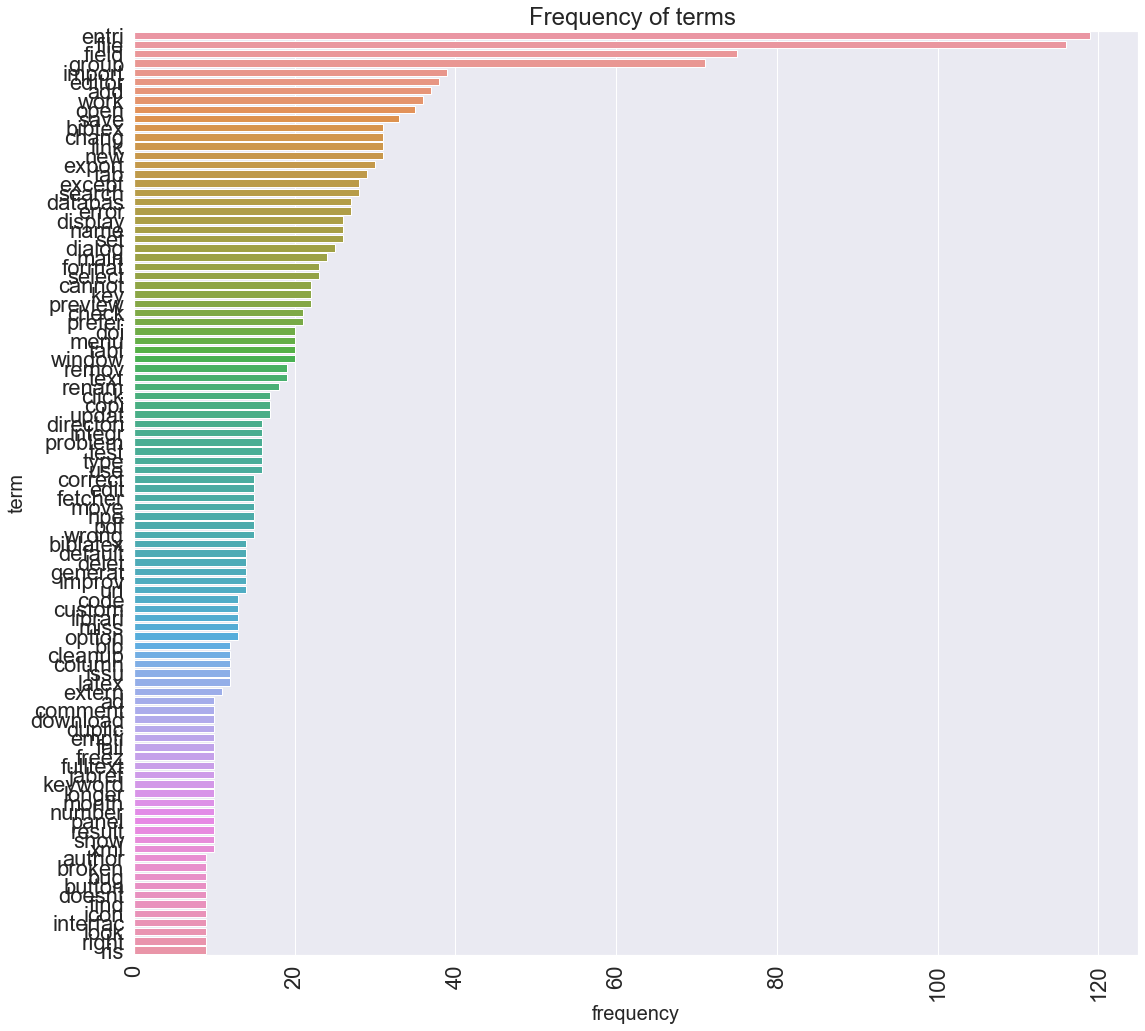

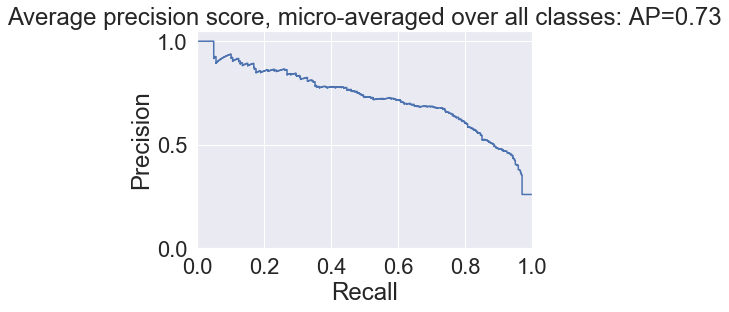

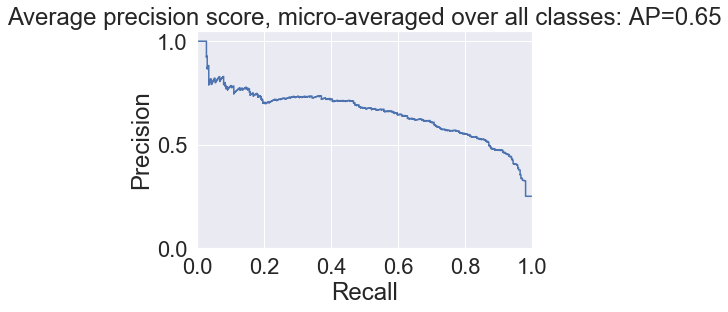

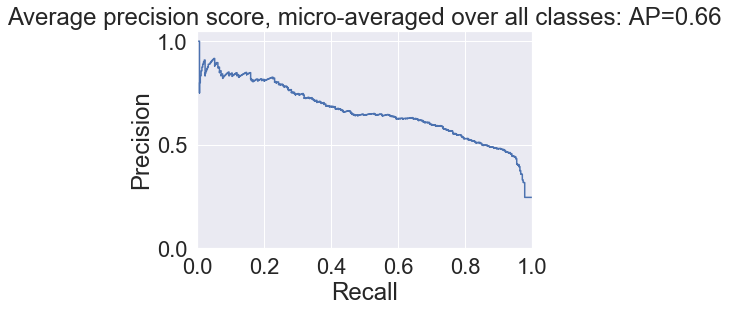

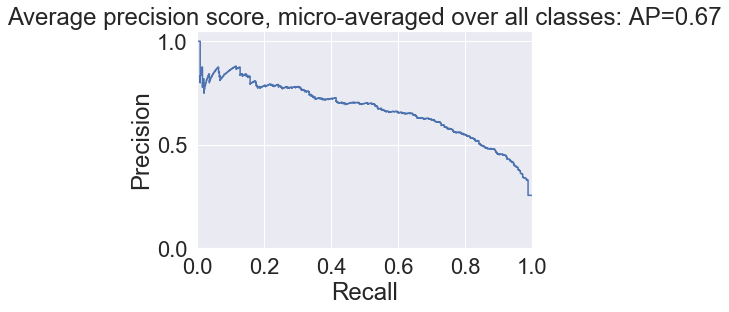

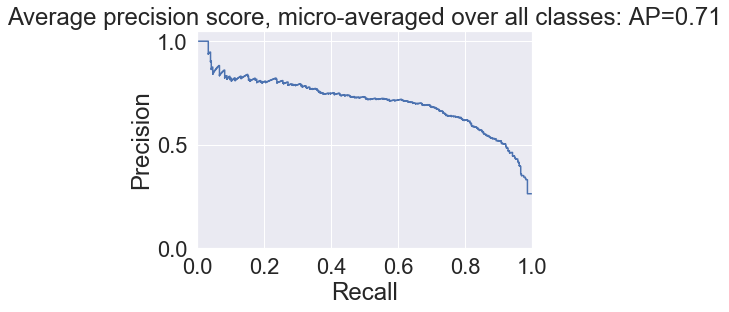

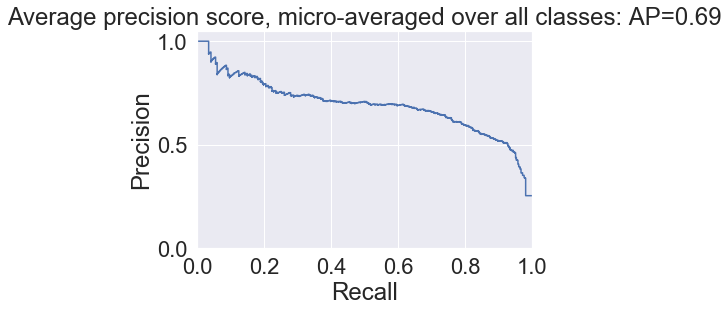

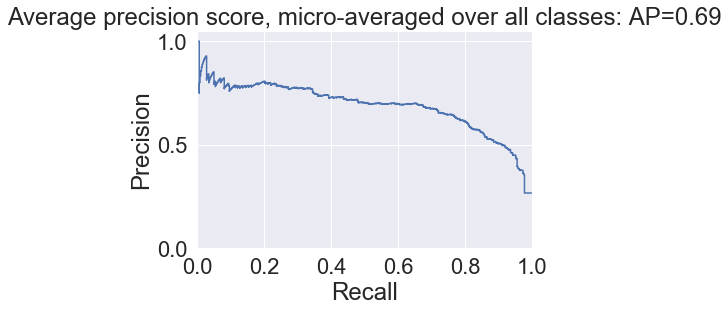

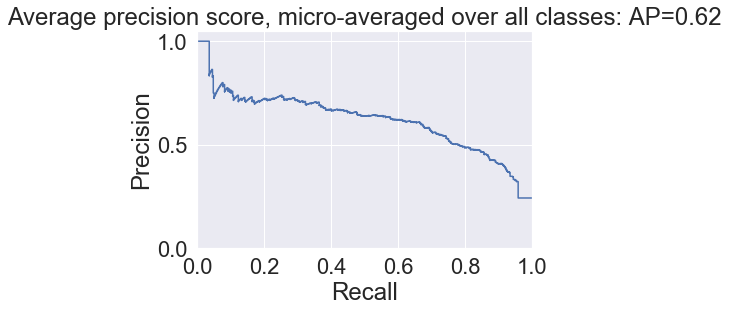

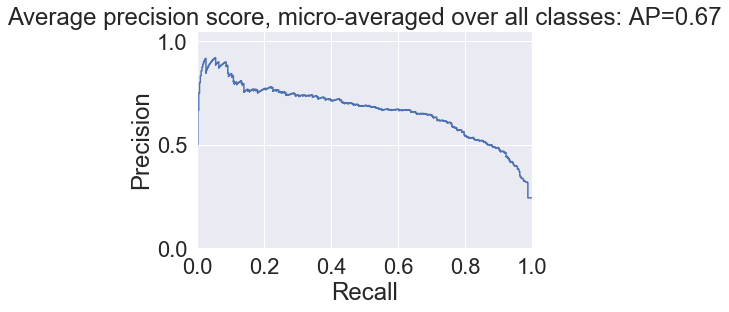

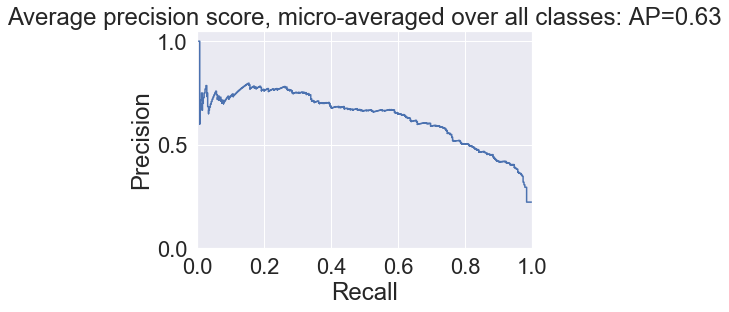

In [203]:
__main__()
